**Импорт данных**

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm #библиотека для построения и диагностики статистических моделей
from IPython.display import display  # Импорт функции display

data = "https://docs.google.com/spreadsheets/d/e/2PACX-1vT3ngqee58458SlDjcKKLzsBRZ_AW9kRz7JMLfz-prIkyXrUfgBfg_ZReR-bbzOgihpe4JTVRuOOq25/pub?output=csv"
test = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQ6njuql2NpFsYB1LQMtiZ77IT_dANEi2UkYr-Up8lSDmkjyyHleCnhClzWtswer5g9OnWgzOdviXgX/pub?output=csv'
df = pd.read_csv(data)
df_test = pd.read_csv(test)

df.head()

,DEP_DATE,FLTNO,ORIG,DEST,CAP,ORIG_FLT_NUM,DEST_FLT_NUM,ORIG_ATM_PRESS,DEST_ATM_PRESS,PASS_150,...,PASS_10,PASS_9,PASS_8,PASS_7,PASS_6,PASS_5,PASS_4,PASS_3,PASS_2,PASS_1
0,2016-01-01 00:00:00,2632,MOW,AER_1,402,70,2,756,769,7.0,...,294.0,307.0,308.0,321.0,331.0,334.0,330.0,341.0,344.0,344
1,2016-01-01 00:00:00,3384,MOW,AER_2,140,61,30,760,754,2.0,...,70.0,73.0,75.0,75.0,76.0,78.0,85.0,84.0,94.0,103
2,2016-01-01 00:00:00,2876,MOW,AER_3,158,74,17,759,741,4.0,...,46.0,48.0,47.0,47.0,49.0,49.0,57.0,87.0,108.0,116
3,2016-01-01 00:00:00,3144,MOW,AER_4,170,1,40,725,758,4.0,...,56.0,56.0,62.0,68.0,68.0,70.0,79.0,83.0,91.0,99
4,2016-01-01 00:00:00,2209,MOW,AER_5,158,65,0,738,733,2.0,...,43.0,44.0,45.0,47.0,46.0,47.0,51.0,54.0,54.0,60


In [ ]:
# Заполнение пустых значений для PASS_150 - PASS_2

def fill_missing_values(row, df):
    # Получаем индексы и значения непустых элементов
    non_nan_indices = [df.columns.get_loc(col) for col in row.dropna().index] # Берем массив номеров столбцов с непустыми значениями
    non_nan_values = row.dropna().values.tolist() # Массив непустых значений

    # Если в строке меньше двух непустых значений, возвращаем None
    if len(non_nan_values) < 2:
        return None

    # Если есть хотя бы два непустых элемента
    if len(non_nan_values) >= 2:
        for i in range(1, len(non_nan_values)):
            index1 = non_nan_indices[i-1]  # Индекс первого значения
            index2 = non_nan_indices[i]    # Индекс второго значения
            value1 = non_nan_values[i-1]   # Первое значение
            value2 = non_nan_values[i]     # Второе значение

            # Заполняем пропуски между двумя непустыми значениями
            for j in range(index1 + 1, index2):
                row[j] = (j - index1) * (value2 - value1) / (index2 - index1) + value1
    return row

# Применяем функцию к каждой строке
df_added = df.loc[:, 'PASS_150':'PASS_2']
X_test = df_test.loc[:, 'PASS_150':'PASS_31']

df_added = df_added.apply(fill_missing_values, axis=1, df=df_added) # Заполнение строк
X_test.apply(fill_missing_values, axis=1, df=X_test)
df_added = df_added.dropna(how='any') # Удаление строк, в которых меньше 2 непустых значений
X_test = X_test.dropna(how='any')

<ipython-input-2-a81f307263f0>:22: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  row[j] = (j - index1) * (value2 - value1) / (index2 - index1) + value1
<ipython-input-2-a81f307263f0>:22: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  row[j] = (j - index1) * (value2 - value1) / (index2 - index1) + value1


In [ ]:
df1 = df.loc[:, 'CAP':'DEST_ATM_PRESS']
df1 = df1.merge(df_added, how='inner', left_index=True, right_index=True)
df1 = df1.merge(df['PASS_1'], how='inner', left_index=True, right_index=True) # Объединение заполненного датафрейма (PASS_150 - PASS_2) с начальной таблицей

X = df1.loc[:, 'CAP':'PASS_2']
Y = df1['PASS_1']
X.head()

,CAP,ORIG_FLT_NUM,DEST_FLT_NUM,ORIG_ATM_PRESS,DEST_ATM_PRESS,PASS_150,PASS_149,PASS_148,PASS_147,PASS_146,...,PASS_11,PASS_10,PASS_9,PASS_8,PASS_7,PASS_6,PASS_5,PASS_4,PASS_3,PASS_2
0,402,70,2,756,769,7.0,7.0,7.0,7.0,7.0,...,293.0,294.0,307.0,308.0,321.0,331.0,334.0,330.0,341.0,344.0
1,140,61,30,760,754,2.0,2.0,2.0,2.0,2.0,...,66.0,70.0,73.0,75.0,75.0,76.0,78.0,85.0,84.0,94.0
2,158,74,17,759,741,4.0,4.0,3.0,3.0,3.0,...,45.0,46.0,48.0,47.0,47.0,49.0,49.0,57.0,87.0,108.0
3,170,1,40,725,758,4.0,4.0,4.0,4.0,4.0,...,56.0,56.0,56.0,62.0,68.0,68.0,70.0,79.0,83.0,91.0
4,158,65,0,738,733,2.0,2.0,2.0,2.0,2.0,...,41.0,43.0,44.0,45.0,47.0,46.0,47.0,51.0,54.0,54.0


**Модель линейной регрессии**

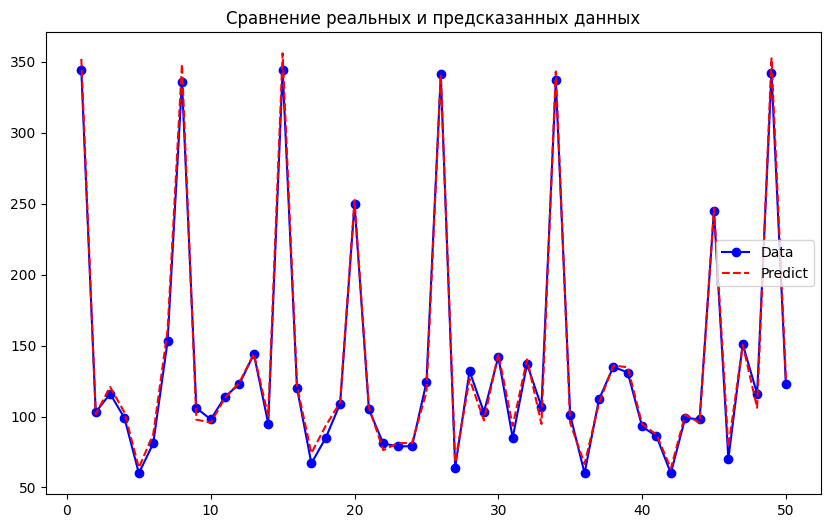

In [ ]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Построение модели множественной линейной регрессии
model = LinearRegression()
model.fit(X, Y)

# Прогнозирование на обучающей и тестовой выборках
y_pred = model.predict(X)

plt.figure(figsize=(10, 6))

i = np.arange(1, 51, 1)
plt.plot(i.transpose(), Y[:50], 'bo-', label="Data")
plt.plot(i.transpose(), y_pred[:50], 'r--', label="Predict")

plt.title('Сравнение реальных и предсказанных данных')
plt.legend()
plt.show()

In [ ]:
import sklearn.metrics as metrics

print("Метрики:")
print('R2:\t', round(metrics.r2_score(Y, y_pred), 4))
print('MAE:\t', round(metrics.mean_absolute_error(Y, y_pred), 4))
print('MSE:\t', round(metrics.mean_squared_error(Y, y_pred), 4))

coef = model.coef_
x_names = X.columns

# Получаем индексы наибольших коэффициентов
max_i = np.argsort(np.abs(coef))[-10:]

# Получаем наибольшие коэффициенты и соответствующие им названия признаков
max_x = coef[max_i]
max_x_names = x_names[max_i]

# Выводим результат
print('\nСамые значимые факторы:')
for name, coef in zip(max_x_names, max_x):
    print(name, ': ', round(coef, 4))

Метрики:
R2:	 0.992
MAE:	 4.984
MSE:	 58.4573

Самые значимые факторы:
PASS_94 :  0.0622
PASS_16 :  -0.0652
CAP :  0.0726
PASS_28 :  0.074
PASS_30 :  -0.0759
PASS_135 :  0.0861
PASS_102 :  -0.0918
PASS_9 :  -0.1241
PASS_3 :  -0.1825
PASS_2 :  1.1847


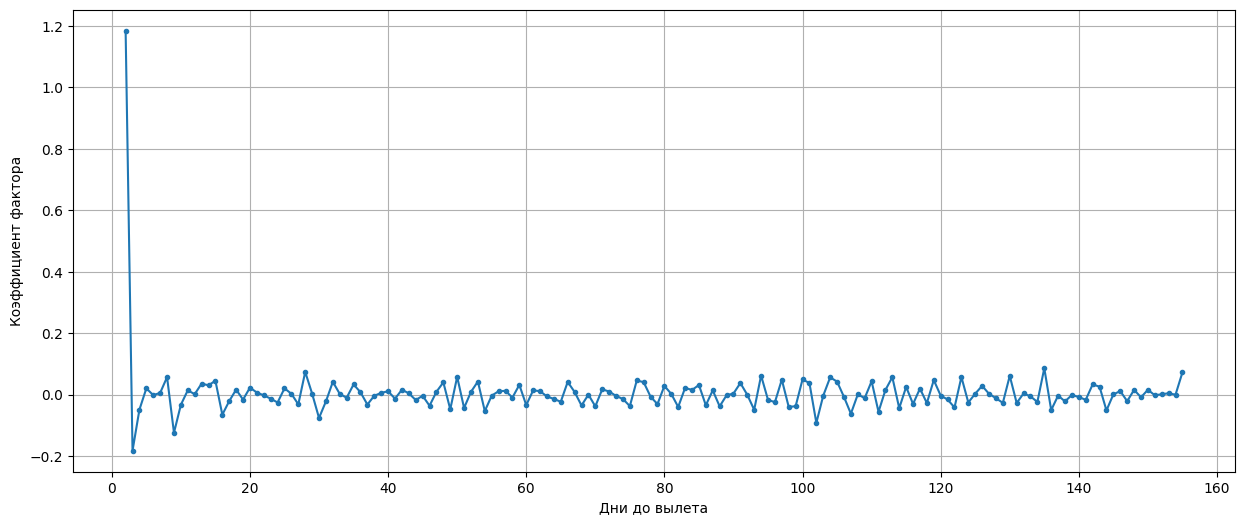

In [ ]:
import matplotlib.pyplot as plt

i = np.arange(155, 1, -1)
plt.figure(figsize=(15, 6))
plt.plot(i.transpose(), model.coef_, marker='.')

# Добавляем подписи и заголовки
plt.xlabel('Дни до вылета')
plt.ylabel('Коэффициент фактора')
plt.grid(True)

# Отображаем график
plt.show()

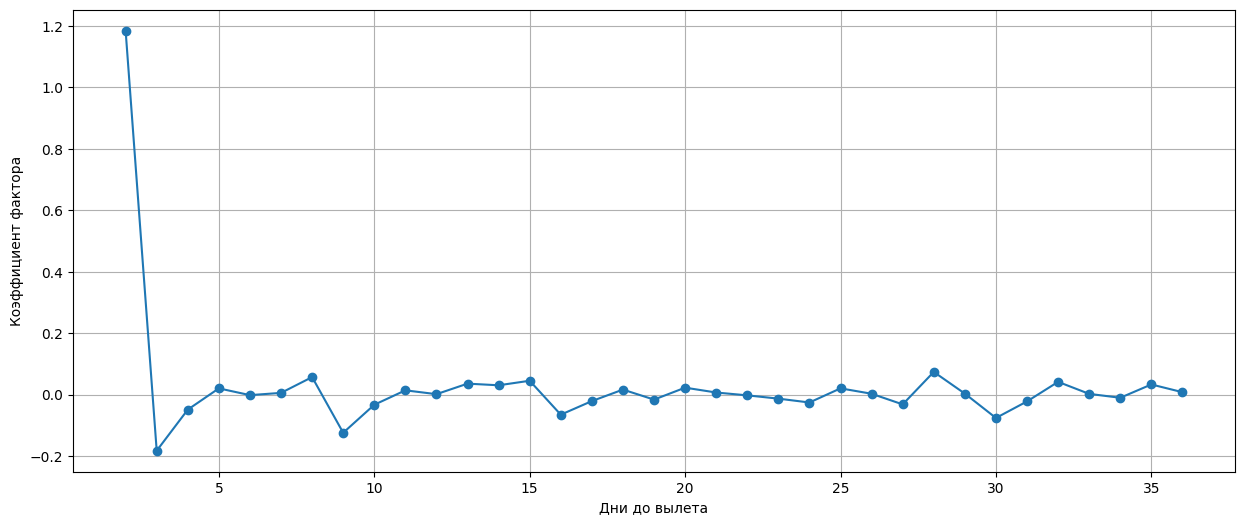

In [ ]:
i1 = i[119:]
c1 = model.coef_[119:]

plt.figure(figsize=(15, 6))
plt.plot(i1.transpose(), c1, marker='o')

# Добавляем подписи и заголовки
plt.xlabel('Дни до вылета')
plt.ylabel('Коэффициент фактора')
plt.grid(True)

# Отображаем график
plt.show()

**Модель на основе временных рядов**

Прогноз на 1 день

In [ ]:
import xgboost as xgb

X1 = X.loc[:, 'PASS_150':] # Берем данные о купленных билетах за 150-2 дней до вылета
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(X1, Y)

y_1d = model.predict(X1)

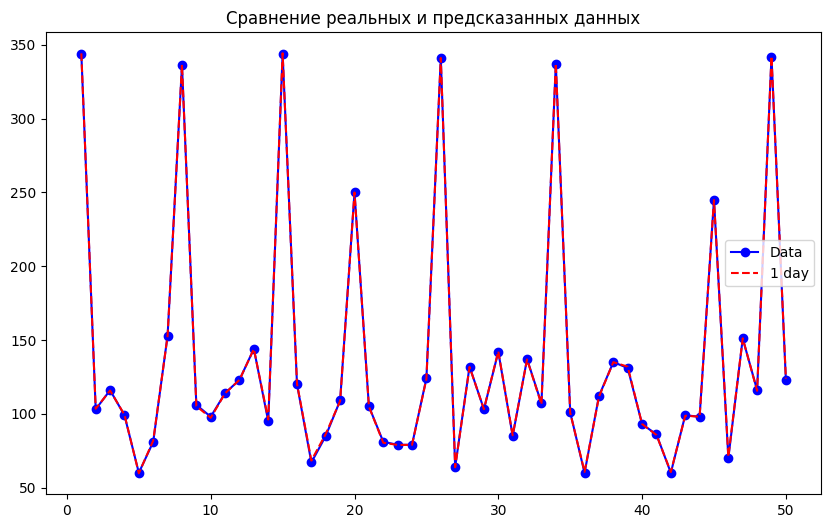

In [ ]:
plt.figure(figsize=(10, 6))

i = np.arange(1, 51, 1)
plt.plot(i.transpose(), Y[:50], 'bo-', label="Data")
plt.plot(i.transpose(), y_1d[:50], linestyle='--', color='red', label="1 day")

plt.title('Сравнение реальных и предсказанных данных')
plt.legend()
plt.show()

In [ ]:
import sklearn.metrics as metrics

print("Метрики:")
print('R2:\t', round(metrics.r2_score(Y, y_1d), 5))
print('MAE:\t', round(metrics.mean_absolute_error(Y, y_1d), 5))
print('MSE:\t', round(metrics.mean_squared_error(Y, y_1d), 5))

Метрики:
R2:	 0.99993
MAE:	 0.5291
MSE:	 0.54864


Прогноз за месяц

In [ ]:
X30 = X.loc[:, 'PASS_150':'PASS_31'] # Берем данные о купленных билетах за 150-30 дней до вылета
Y30 = df1.loc[:, 'PASS_30':]

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500)
model.fit(X30, Y30)

data_pred = model.predict(X30) # Прогноз для данных из таблицы Data
test_pred30 = model.predict(X_test) # Прогноз для данных из таблицы Test

In [ ]:
import sklearn.metrics as metrics

print("Метрики:")
print('R2:\t', round(metrics.r2_score(Y30.loc[:, 'PASS_1'], data_pred[:, 29]), 5))
print('MAE:\t', round(metrics.mean_absolute_error(Y30.loc[:, 'PASS_1'], data_pred[:, 29]), 5))
print('MSE:\t', round(metrics.mean_squared_error(Y30.loc[:, 'PASS_1'], data_pred[:, 29]), 5))

Метрики:
R2:	 0.98455
MAE:	 7.77784
MSE:	 113.10592


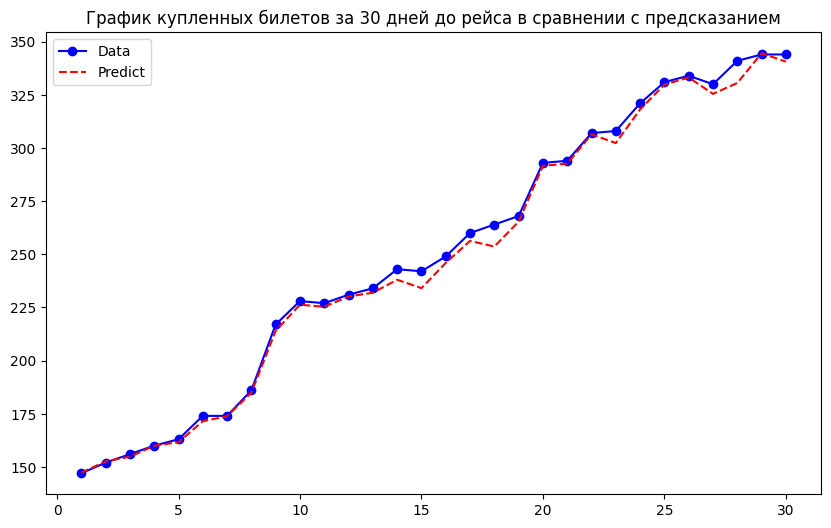

In [ ]:
plt.figure(figsize=(10, 6))

flight = 0 # Рейс
i = np.arange(1, 31, 1)
plt.plot(i.transpose(), Y30.loc[flight, :], 'bo-', label="Data")
plt.plot(i.transpose(), data_pred[flight, :], linestyle='--', color='red', label="Predict")

plt.title('График купленных билетов за 30 дней до рейса в сравнении с предсказанием')
plt.legend()
plt.show()

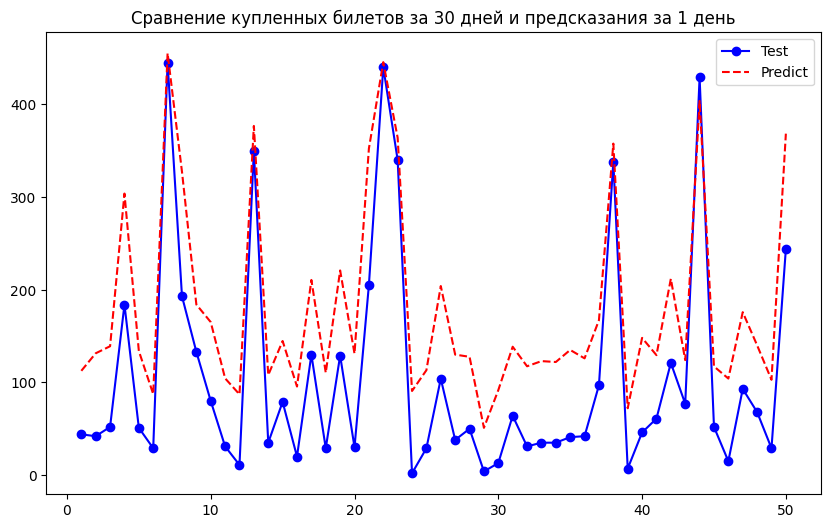

In [ ]:
plt.figure(figsize=(10, 6))

i = np.arange(1, 51, 1)
plt.plot(i.transpose(), X_test.loc[:53, 'PASS_31'], 'bo-', label="Test")
plt.plot(i.transpose(), test_pred30[:50, 29], linestyle='--', color='red', label="Predict")

plt.title('Сравнение купленных билетов за 30 дней до вылета и предсказания за 1 день')
plt.legend()
plt.show()

Shag 3

<ipython-input-18-b747b3c84c08>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Dif = Xd.diff(axis=1) # Разница между соседними днями (активность бронирования/отмены)


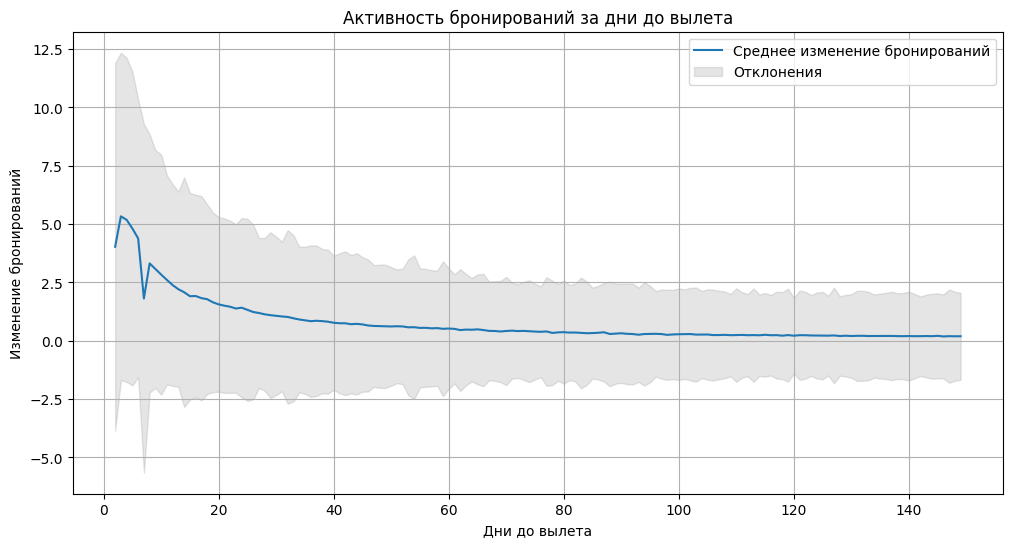

In [ ]:
Xd = df_added
Dif = Xd.diff(axis=1) # Разница между соседними днями (активность бронирования/отмены)
Dif = Dif.drop(columns=['PASS_150'])

# Построим график изменения бронирований по дням
days = range(149, 1, -1)
avg_diff = Dif.mean(axis=0) # Среднее изменение бронирований по дням
std_diff = Dif.std(axis=0) # Стандартное отклонение для каждой разницы

plt.figure(figsize=(12, 6))
plt.plot(days, avg_diff, label='Среднее изменение бронирований')
plt.fill_between(days, avg_diff - std_diff, avg_diff + std_diff, color='gray', alpha=0.2, label='Отклонения')
plt.xlabel('Дни до вылета')
plt.ylabel('Изменение бронирований')
plt.title('Активность бронирований за дни до вылета')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
reserv = Dif.where(Dif > 0) # Берем только значения бронирований

reserv = reserv.mean(axis=0) # Считаем среднее значение бронирований по дням

n = 5
top_res = reserv.nlargest(n) # Берем топ n дней по кол-ву бронирований

print(f"Топ-{n} дней с наибольшим кол-вом бронирований:")
print(round(top_res, 3))

Топ-5 дней с наибольшим кол-вом бронирований:
PASS_2    7.406
PASS_3    6.843
PASS_4    6.663
PASS_5    6.251
PASS_6    5.794
dtype: float64


In [ ]:
cancel = Dif.where(Dif < 0) # Берем только значения отмен бронирования

cancel = cancel.mean(axis=0) # Считаем среднее значение отмен по дням

n = 5
top_cancel = cancel.nsmallest(n) # Берем топ n дней по кол-ву отмен бронирования

print(f"Топ-{n} дней с наибольшими отменами бронирований:")
print(round(top_cancel, 3))

Топ-5 дней с наибольшими отменами бронирований:
PASS_7     -8.986
PASS_145   -3.419
PASS_144   -3.359
PASS_147   -3.342
PASS_132   -3.338
dtype: float64


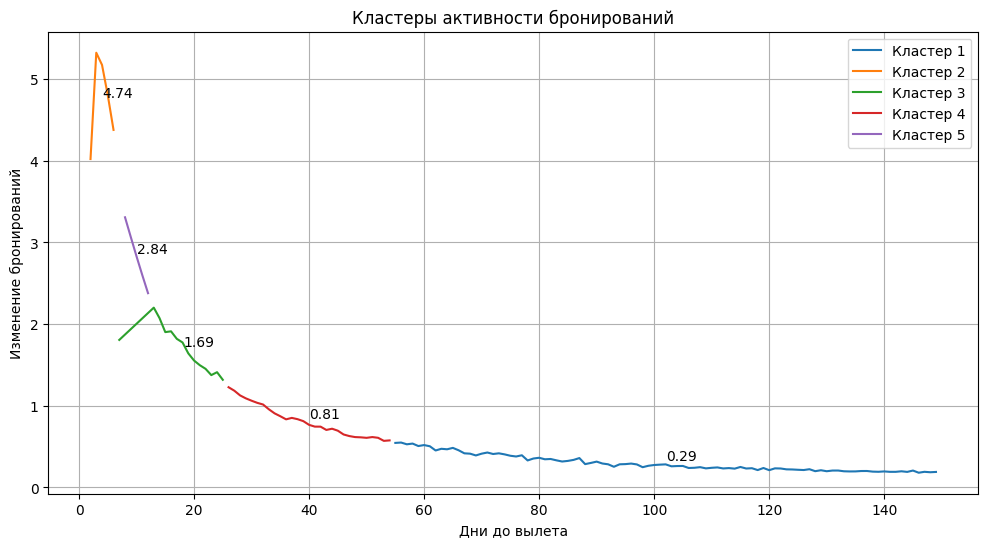

Информация по кластерам:
Дни: 55 - 149	Среднее изменение: 0.29492054350015157
Дни: 2 - 6	Среднее изменение: 4.739194650073311
Дни: 7 - 25	Среднее изменение: 1.6933843701626128
Дни: 26 - 54	Среднее изменение: 0.8135128069480978
Дни: 8 - 12	Среднее изменение: 2.8350141258091046


<ipython-input-24-f455be1bb408>:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Дни: {cluster_data['days'][0]} - {cluster_data['days'][len(cluster_data['days'])-1]}\tСреднее изменение: {cluster_data['avg_diff'].mean()}")


In [ ]:
from sklearn.cluster import KMeans

# Преобразуем средние изменения в массив для кластеризации
avg_diff1 = avg_diff.values.reshape(-1, 1)

n = 5 # Кол-во кластеров

# Применяем K-means для поиска периодов с похожими изменениями бронирований
kmeans = KMeans(n_clusters=n, random_state=0).fit(avg_diff1)

# Метки кластеров для каждого дня
clusters = kmeans.labels_

# Добавим к среднему изменению информацию о кластерах
df_clusters = pd.DataFrame({
    'days': days,
    'avg_diff': avg_diff,
    'cluster': clusters
})

# Сортировка по дням до вылета
df_clusters = df_clusters.sort_values(by='days', ascending=True)

# Визуализация
plt.figure(figsize=(12, 6))

for cluster in range(n):
    cluster_data = df_clusters[df_clusters['cluster'] == cluster]

    # Построение линии для каждого кластера
    plt.plot(cluster_data['days'], cluster_data['avg_diff'], label=f'Кластер {cluster + 1}')

    # Вычисление среднего значения изменений бронирований для текущего кластера
    avg_change = cluster_data['avg_diff'].mean()

    # Находим середину по x для текущего кластера (используем среднее по дням)
    x_pos = cluster_data['days'].mean()

    # Добавляем подпись среднего значения изменения бронирований на график
    plt.text(x_pos, avg_change, f'{avg_change:.2f}', fontsize=10,
             verticalalignment='bottom', horizontalalignment='left', color='black')

plt.xlabel('Дни до вылета')
plt.ylabel('Изменение бронирований')
plt.title('Кластеры активности бронирований')
plt.legend()
plt.grid(True)
plt.show()

print("Информация по кластерам:")
for cluster in range(n):
  cluster_data = df_clusters[df_clusters['cluster'] == cluster]
  print(f"Дни: {cluster_data['days'][0]} - {cluster_data['days'][len(cluster_data['days'])-1]}\tСреднее изменение: {cluster_data['avg_diff'].mean()}")